In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from skimage.transform import resize
from keras import regularizers
from keras import callbacks
from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Dropout, Activation, Flatten, Input, Conv2D, MaxPooling2D, UpSampling2D, GlobalMaxPooling1D
from keras.layers import BatchNormalization, Lambda, Convolution1D, Convolution2D, ELU, concatenate, Conv1D
from keras.utils import np_utils
import skimage
import itertools
import nltk
import string
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, auc
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping  
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## 1 Autoencoder

###1.1 Data Prepocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load file
def unpickle2(file):
    import pickle
    dic = {}
    images = np.zeros([10000, 3,32,32])
    labels = []
    with open(file, 'rb') as fo:
        dic = pickle.load(fo, encoding='bytes')
        images = np.r_[images, dic[b"data"].reshape([-1,3,32,32])]
        labels.append(dic[b"labels"])
    dic["images"] = images[10000:].transpose(0,2,3,1)
    dic["images"] = dic["images"]/255
    dic["labels"] = np.array(labels).reshape([-1, 1]) 
    return dic

In [ ]:
#load data
t1=unpickle2("drive/MyDrive/Colab Notebooks/cifar-10-batches-py/data_batch_1")
t2=unpickle2("drive/MyDrive/Colab Notebooks/cifar-10-batches-py/data_batch_2")
t3=unpickle2("drive/MyDrive/Colab Notebooks/cifar-10-batches-py/data_batch_3")
t4=unpickle2("drive/MyDrive/Colab Notebooks/cifar-10-batches-py/data_batch_4")
t5=unpickle2("drive/MyDrive/Colab Notebooks/cifar-10-batches-py/data_batch_5")
dic_test=unpickle2("drive/MyDrive/Colab Notebooks/cifar-10-batches-py/test_batch")

In [ ]:
#prepare dataset
import itertools
x_train=np.concatenate((t1["images"],t2["images"],t3["images"],t4["images"],t5["images"]),axis=0)
y_train=np.concatenate((t1["labels"],t2["labels"],t3["labels"],t4["labels"],t5["labels"]),axis=0)
y_train=np.array(list(itertools.chain.from_iterable(y_train)))
x_test=dic_test["images"]
y_test=dic_test["labels"]
y_test=np.array(list(itertools.chain.from_iterable(y_test)))

In [ ]:
#check shape
x_train.shape
y_train.shape

x_test.shape
y_test.shape

(10000,)

In [ ]:
#match label number and the name
def unpickle(file):
    import pickle
    labels = []
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dic

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
names=unpickle("drive/MyDrive/Colab Notebooks/cifar-10-batches-py/batches.meta")
#names[b'label_names'][2]
#names[b'label_names'][y_train[2]]

In [ ]:
names[b'label_names']

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

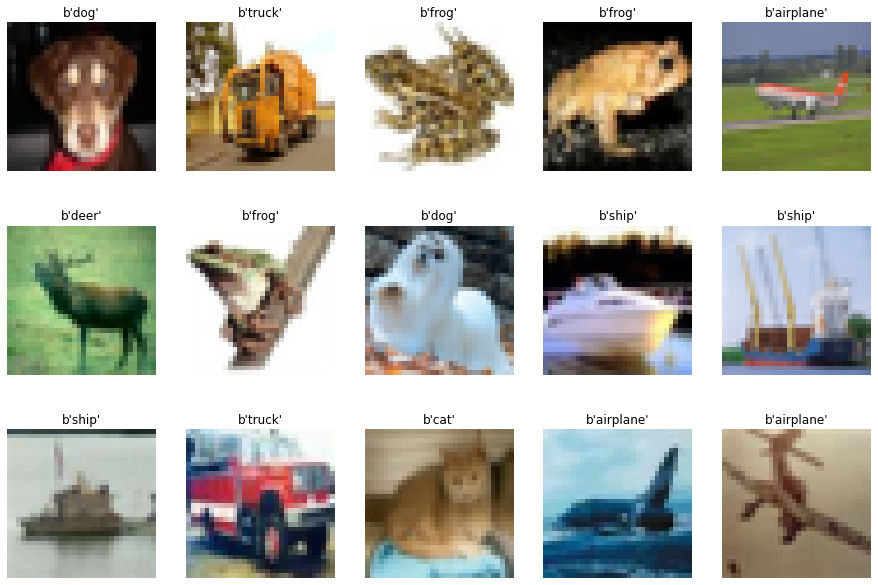

In [ ]:
#show some images with labels
import matplotlib.pyplot as plt
from random import randint
f,ax = plt.subplots(3,5) 
f.subplots_adjust(0,0,2,2)
for i in range(0,3,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(x_train))
        ax[i,j].imshow(x_train[rnd_number])
        ax[i,j].set_title((names[b'label_names'][y_train[rnd_number]]))
        ax[i,j].axis('off')

### 1.2 Convolutional Autoencoder

In [ ]:
import keras
from keras import layers

input_img = keras.Input(shape=(32, 32, 3))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
#x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)


x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
#x = layers.UpSampling2D((2, 2))(x)
#x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (1, 1), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


In [ ]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.summary()

Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 8, 8, 16)          2320      
_________________________________________________________________
up_sampling2d_56 (UpSampling (None, 16, 16, 16)      

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
# Fit the model
from keras import callbacks
from keras.callbacks import EarlyStopping 
callbacks = [EarlyStopping(monitor='val_loss',min_delta=0,patience=6,verbose=1,mode='auto')]

autoencoder_history = autoencoder.fit(x_train, x_train,
                                      epochs=20,
                                      batch_size=128,
                                      validation_data=(x_test, x_test),
                                      callbacks=callbacks)

Epoch 1/20
391/391 [==============================] - 150s 384ms/step - loss: 0.9104 - val_loss: 0.1085
Epoch 2/20
391/391 [==============================] - 151s 386ms/step - loss: 0.5878 - val_loss: 0.0564
Epoch 3/20
391/391 [==============================] - 151s 386ms/step - loss: 0.5769 - val_loss: 0.0327
Epoch 4/20
391/391 [==============================] - 152s 388ms/step - loss: 0.5741 - val_loss: 0.0250
Epoch 5/20
391/391 [==============================] - 153s 391ms/step - loss: 0.5722 - val_loss: 0.0261
Epoch 6/20
391/391 [==============================] - 153s 391ms/step - loss: 0.5708 - val_loss: 0.0279
Epoch 7/20
391/391 [==============================] - 153s 392ms/step - loss: 0.5692 - val_loss: 0.0253
Epoch 8/20
391/391 [==============================] - 153s 392ms/step - loss: 0.5680 - val_loss: 0.0246
Epoch 9/20
391/391 [==============================] - 151s 386ms/step - loss: 0.5673 - val_loss: 0.0189
Epoch 10/20
391/391 [==============================] - 151s 387m

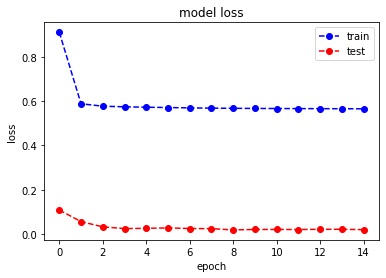

In [ ]:
# Plot the train and test loss
plt.plot(autoencoder_history.history['loss'],'bo--')
plt.plot(autoencoder_history.history['val_loss'], 'ro--')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


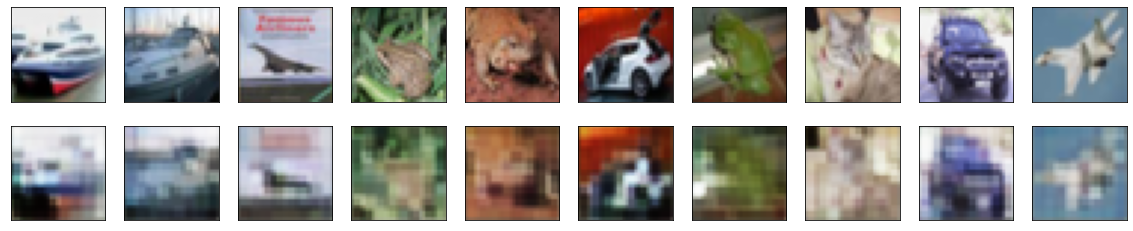

In [ ]:
decoded_imgs = autoencoder.predict(x_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(32, 32,3))
    #plt.set_title((names[b'label_names'][y_test[i]]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2  Image Classification

We’ll continue to use the CIFAR10 dataset and build a deep convolutional
network for classification.

### 2.1 Deep CNN

Build a deep CNN to classify the images. Provide a brief description of the
architectural choices you’ve made: kernel sizes, strides, padding, network depth.
Train your network end-to-end. Report on your model’s performance on training
set and test set.

####2.1.1 Build Deep CNN Model

Description of the architectural choices：


*   kernel sizes:(3,3)
*   strides: 1 x 1
*   padding:same
*   network depth : 3



In [ ]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [ ]:
y_test.shape

(10000, 10)

In [ ]:
# Build deep cnn model
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', input_shape=(32,32,3))) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=75, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 75)        43275     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 75)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 75)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)        

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_history = model.fit(x_train, y_train,
                                epochs=20,batch_size=128,
                                validation_data=(x_test, y_test))

Epoch 1/20
391/391 [==============================] - 210s 537ms/step - loss: 1.6453 - accuracy: 0.3882 - val_loss: 1.3716 - val_accuracy: 0.4939
Epoch 2/20
391/391 [==============================] - 211s 540ms/step - loss: 1.3273 - accuracy: 0.5230 - val_loss: 1.2255 - val_accuracy: 0.5652
Epoch 3/20
391/391 [==============================] - 212s 542ms/step - loss: 1.1647 - accuracy: 0.5859 - val_loss: 1.0219 - val_accuracy: 0.6394
Epoch 4/20
391/391 [==============================] - 213s 545ms/step - loss: 1.0590 - accuracy: 0.6274 - val_loss: 0.9254 - val_accuracy: 0.6744
Epoch 5/20
391/391 [==============================] - 208s 532ms/step - loss: 0.9881 - accuracy: 0.6544 - val_loss: 0.8693 - val_accuracy: 0.6991
Epoch 6/20
391/391 [==============================] - 208s 532ms/step - loss: 0.9309 - accuracy: 0.6758 - val_loss: 0.8179 - val_accuracy: 0.7202
Epoch 7/20
391/391 [==============================] - 213s 544ms/step - loss: 0.8910 - accuracy: 0.6908 - val_loss: 0.7806 -

####2.1.2 Deep CNN Model Performance 

In [29]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(20,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "train")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "test")
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "train")
    plt.plot(history.history['val_loss'], 'ro--', label = "test")
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

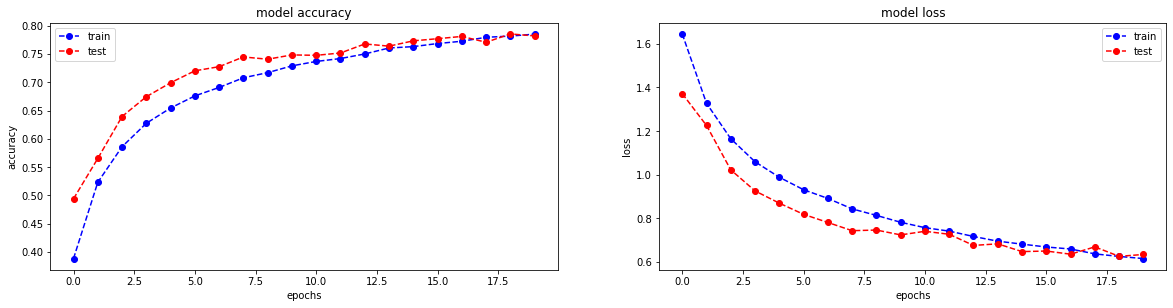

In [ ]:
plot_accuracy_loss(model_history)

In [ ]:
#test data loss and accuracy
print("test data loss and accuracy: ", model.evaluate(x_test, y_test, verbose=1))
#train data loss and accuracy
print("train data loss and accuracy: " ,model.evaluate(x_train, y_train, verbose=1))

313/313 [==============================] - 12s 37ms/step - loss: 0.6339 - accuracy: 0.7819
test data loss and accuracy:  [0.6339058876037598, 0.7818999886512756]
1563/1563 [==============================] - 57s 36ms/step - loss: 0.3677 - accuracy: 0.8763
train data loss and accuracy:  [0.3677235543727875, 0.8763399720191956]


### 2.2 Transfer Learning

Repeat the same task, but this time utilize a pre-trained network for the majority of your model. You should only train the final Dense layer, all other weights
should be fixed. You can use whichever pre-trained backbone you like (ResNet,
VGG, etc). Report on your model’s performance on training set and test set.

#### 2.2.1 Build VGG16 Model

In [ ]:
#reshape data
from keras.applications import VGG16

# include top should be False to remove the softmax layer
pretrained_model = VGG16(include_top=False, weights='imagenet',input_shape=(32,32,3))
#pretrained_model.summary()

In [ ]:
# Add dense layer
model2 = Sequential()
model2.add(pretrained_model)
model2.add(Flatten())
model2.add(Dense(256, activation="relu"))
model2.add(Dropout(0.4))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.3))

model2.add(Dense(10, activation="softmax"))   
model2.trainable = False

In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model2_history = model.fit(x_train, y_train,
                           epochs=20,batch_size=128,
                           validation_data=(x_test, y_test))

Epoch 1/20
391/391 [==============================] - 208s 531ms/step - loss: 0.6062 - accuracy: 0.7891 - val_loss: 0.6405 - val_accuracy: 0.7802
Epoch 2/20
391/391 [==============================] - 210s 538ms/step - loss: 0.5922 - accuracy: 0.7940 - val_loss: 0.6178 - val_accuracy: 0.7896
Epoch 3/20
391/391 [==============================] - 209s 535ms/step - loss: 0.5869 - accuracy: 0.7960 - val_loss: 0.6037 - val_accuracy: 0.7902
Epoch 4/20
391/391 [==============================] - 209s 535ms/step - loss: 0.5788 - accuracy: 0.7987 - val_loss: 0.6088 - val_accuracy: 0.7936
Epoch 5/20
391/391 [==============================] - 211s 539ms/step - loss: 0.5620 - accuracy: 0.8047 - val_loss: 0.6078 - val_accuracy: 0.7906
Epoch 6/20
391/391 [==============================] - 208s 533ms/step - loss: 0.5583 - accuracy: 0.8056 - val_loss: 0.6142 - val_accuracy: 0.7948
Epoch 7/20
391/391 [==============================] - 209s 535ms/step - loss: 0.5506 - accuracy: 0.8080 - val_loss: 0.6033 -

#### 2.2.2 VGG16 Model Performance

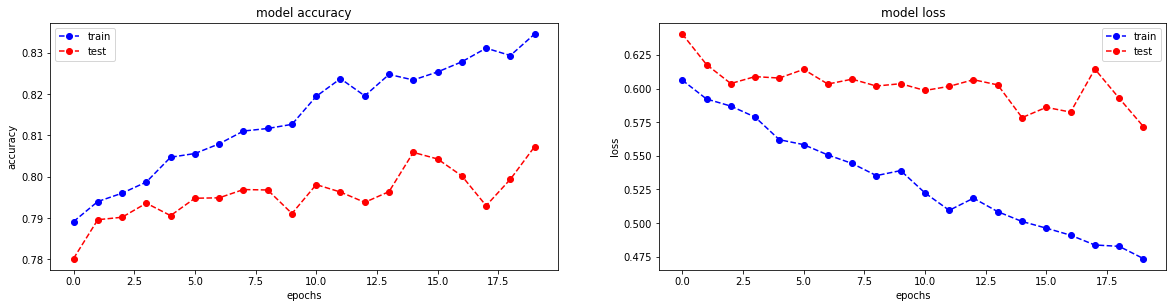

In [ ]:
plot_accuracy_loss(model2_history)

In [ ]:
#test data loss and accuracy
print("test data loss and accuracy: ", model2.evaluate(x_test, y_test, verbose=1))
#train data loss and accuracy
print("train data loss and accuracy: " ,model2.evaluate(x_train, y_train, verbose=1))

313/313 [==============================] - 109s 347ms/step - loss: 2.3684 - accuracy: 0.0879
test data loss and accuracy:  [2.368396282196045, 0.08789999783039093]
1563/1563 [==============================] - 548s 351ms/step - loss: 2.3703 - accuracy: 0.0866
train data loss and accuracy:  [2.3702542781829834, 0.08662000298500061]


## 3 Text Classification



### 3.1 RNN

Build and train a Recurrent Neural Network to solve this text classification
task. You can use any type of RNN you wish (SimpleRNN, GRU, LSTM).

In [3]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/SPAM_detection.csv', sep=',')
df.rename(columns={'category_val':'label','Message':'msg'},inplace=True)
df.head(5)

,msg,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
import string
from nltk.corpus import stopwords
def text_process(mess):

    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    #remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])
  
df['clean_msg'] = df.msg.apply(text_process)

In [6]:
df.head(5)

,msg,label,clean_msg
0,"Go until jurong point, crazy.. Available only ...",0,Go jurong point crazy Available bugis n great ...
1,Ok lar... Joking wif u oni...,0,Ok lar Joking wif oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,Free entry wkly comp win FA Cup final tkts 21s...
3,U dun say so early hor... U c already then say...,0,dun say early hor c already say
4,"Nah I don't think he goes to usf, he lives aro...",0,Nah think goes usf lives around though


In [7]:
X = df.clean_msg
y = df.label
print(X.shape)
print(y.shape)

(5572,)
(5572,)


In [19]:
# Split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=666)

In [20]:
#Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
word_dict = tokenizer.index_word
print(len(word_dict))

8682


In [21]:
#Create sequences from sentences
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)
print(x_train_seq[:5])
print(x_train[:5])

[[1894, 90, 207, 299, 1895, 1896, 215], [729, 68, 52, 255, 3793, 990], [131, 14, 1897, 22, 3794, 1898, 3795, 361, 730, 3796, 5, 3797, 5, 3798, 5, 1899, 5], [549, 125, 300, 96, 118, 2481, 1, 3799, 1293, 1116, 2482, 2483, 362], [84, 346, 10, 24]]
5044                      ic lol play 9 doors sometime yo
4367                           Mm yes dear look hugging P
3798    First Time History Need Comfort Luxury Sold Pr...
4359    dating service asked contact someone shy CALL ...
3339                                    K bored come home
Name: clean_msg, dtype: object


In [22]:
#Create pads with fix length
train_x= pad_sequences(x_train_seq, maxlen=50, padding='post')
test_x = pad_sequences(x_test_seq, maxlen=50, padding='post')
train_x.shape

(4736, 50)

In [23]:
np.array(y_train)

array([0, 0, 0, ..., 0, 0, 0])

**LSTM Model**

In [26]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=8683, output_dim=64, input_length=50))
lstm_model.add(LSTM(128))
lstm_model.add(Dense(64, activation = 'relu'))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 64)            555712    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 662,849
Trainable params: 662,849
Non-trainable params: 0
_________________________________________________________________


In [27]:
lstm_result = lstm_model.fit(train_x,y_train, epochs=15,
                             batch_size=64, validation_split = 0.2)

Epoch 1/15
60/60 [==============================] - 7s 115ms/step - loss: 0.4464 - accuracy: 0.8545 - val_loss: 0.3508 - val_accuracy: 0.8819
Epoch 2/15
60/60 [==============================] - 6s 108ms/step - loss: 0.1775 - accuracy: 0.9469 - val_loss: 0.1688 - val_accuracy: 0.9325
Epoch 3/15
60/60 [==============================] - 6s 107ms/step - loss: 0.1352 - accuracy: 0.9535 - val_loss: 0.1719 - val_accuracy: 0.9314
Epoch 4/15
60/60 [==============================] - 6s 107ms/step - loss: 0.1175 - accuracy: 0.9601 - val_loss: 0.1812 - val_accuracy: 0.9346
Epoch 5/15
60/60 [==============================] - 7s 109ms/step - loss: 0.1103 - accuracy: 0.9644 - val_loss: 0.1747 - val_accuracy: 0.9357
Epoch 6/15
60/60 [==============================] - 6s 107ms/step - loss: 0.1021 - accuracy: 0.9686 - val_loss: 0.1738 - val_accuracy: 0.9367
Epoch 7/15
60/60 [==============================] - 6s 108ms/step - loss: 0.1311 - accuracy: 0.9702 - val_loss: 0.1783 - val_accuracy: 0.9589
Epoch 

### 3.2 CNN

Build and train a 1D CNN for this text classification task. We recommend you
do a character-level convolution (with character embeddings). You might gain
some insight and inspiration from these text classification approaches:
* http://www.aclweb.org/anthology/D14-1181
* https://arxiv.org/abs/1702.08568

In [33]:
CNN_model = Sequential()
CNN_model.add(Embedding(input_dim=8683, output_dim=64, input_length=50))
CNN_model.add(Conv1D(64, kernel_size = 3, padding='valid', activation='relu', strides=1))
CNN_model.add(GlobalMaxPooling1D())
CNN_model.add(Dropout(0.3))
CNN_model.add(Dense(64, activation='relu'))
CNN_model.add(Dense(1, activation='sigmoid'))

CNN_model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 64)            555712    
_________________________________________________________________
conv1d (Conv1D)              (None, 48, 64)            12352     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 572,289
Trainable params: 572,289
Non-trainable params: 0
________________________________________________

In [34]:
CNN_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
CNN_result= CNN_model.fit(train_x, y_train, 
                          epochs=15,batch_size=64, validation_split = 0.2)

Epoch 1/15
60/60 [==============================] - 1s 20ms/step - loss: 0.4663 - accuracy: 0.8569 - val_loss: 0.3450 - val_accuracy: 0.8819
Epoch 2/15
60/60 [==============================] - 1s 17ms/step - loss: 0.2512 - accuracy: 0.8933 - val_loss: 0.1070 - val_accuracy: 0.9705
Epoch 3/15
60/60 [==============================] - 1s 17ms/step - loss: 0.0522 - accuracy: 0.9852 - val_loss: 0.0713 - val_accuracy: 0.9768
Epoch 4/15
60/60 [==============================] - 1s 17ms/step - loss: 0.0155 - accuracy: 0.9955 - val_loss: 0.0719 - val_accuracy: 0.9747
Epoch 5/15
60/60 [==============================] - 1s 17ms/step - loss: 0.0063 - accuracy: 0.9989 - val_loss: 0.0843 - val_accuracy: 0.9768
Epoch 6/15
60/60 [==============================] - 1s 17ms/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.0821 - val_accuracy: 0.9778
Epoch 7/15
60/60 [==============================] - 1s 17ms/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.0815 - val_accuracy: 0.9789
Epoch 8/15
60

### 3.3 Compare

Be sure to directly compare your two methods with an ROC curve or similar
validation method. Don’t forget to create a train-test split

####**3.3.1 RNN Results**

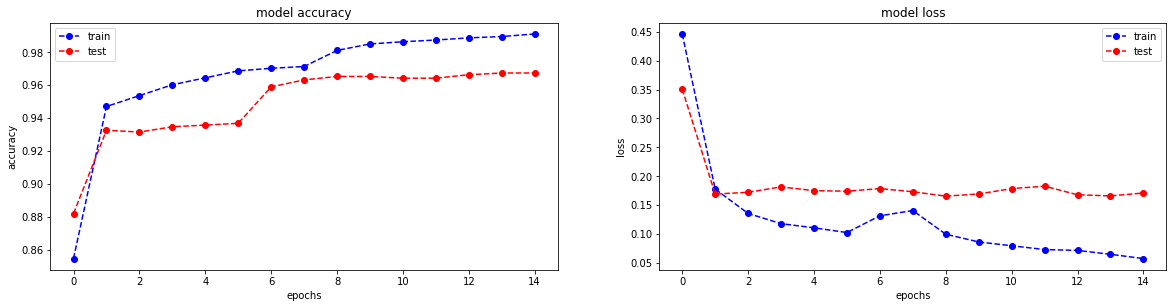

In [30]:
plot_accuracy_loss(lstm_result)

In [31]:
RNN_loss0, RNN_acc0=lstm_model.evaluate(train_x, y_train)
RNN_loss, RNN_acc = lstm_model.evaluate(test_x, y_test)

27/27 [==============================] - 0s 17ms/step - loss: 0.1603 - accuracy: 0.9689


In [32]:
#print("RNN——")
print('RNN loss of train data: %.4f' % RNN_loss0)
print('RNN accuray of train data: %.4f' % (RNN_acc0))
print('RNN loss of test data: %.4f' % RNN_loss)
print('RNN accuray of test data: %.4f' % (RNN_acc))

RNN loss of train data: 0.0708
RNN accuray of train data: 0.9871
RNN loss of test data: 0.1603
RNN accuray of test data: 0.9689


####**3.3.2 CNN Results**

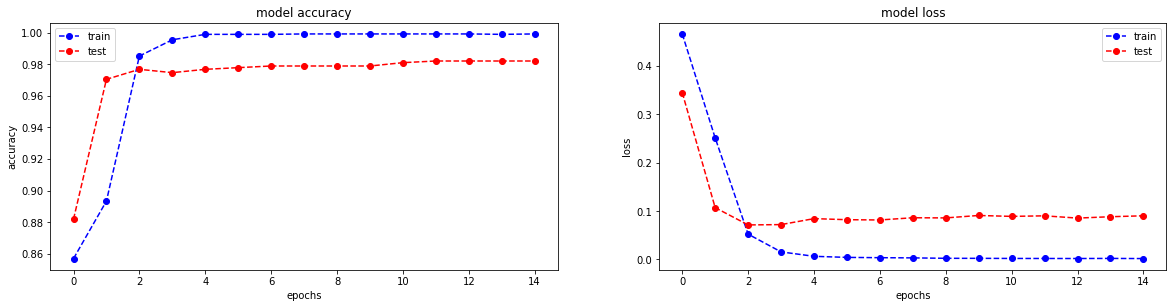

In [35]:
plot_accuracy_loss(CNN_result)

In [37]:
CNN_loss0, CNN_acc0=CNN_model.evaluate(train_x, y_train)
CNN_loss, CNN_acc = CNN_model.evaluate(test_x, y_test)

27/27 [==============================] - 0s 2ms/step - loss: 0.0987 - accuracy: 0.9821


In [38]:
#print("\nCNN——")
print('CNN loss of train data:', CNN_loss0)
print('CNN accuray of train data: %.4f' % (CNN_acc0))
print('CNN loss of test data:', CNN_loss)
print('CNN accuray of test data: %.4f' % (CNN_acc))

CNN loss of train data: 0.019216887652873993
CNN accuray of train data: 0.9958
CNN loss of test data: 0.0987221822142601
CNN accuray of test data: 0.9821


####**3.3.3 ROC & Confusion Matrix of Both**

In [47]:
#predictions
RNN_pre = lstm_model.predict(test_x).ravel()  
CNN_pre = CNN_model.predict(test_x).ravel()  

#ROC
from sklearn.metrics import auc
fpr_RNN, tpr_RNN, thresholds_RNN = roc_curve(y_test, RNN_pre)
auc_RNN = auc(fpr_RNN, tpr_RNN)
fpr_CNN, tpr_CNN, thresholds_CNN = roc_curve(y_test, CNN_pre)
auc_CNN = auc(fpr_CNN, tpr_CNN)

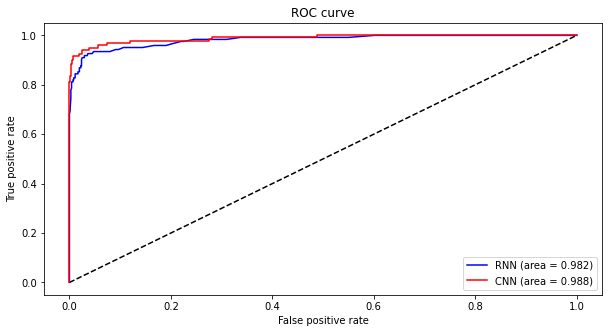

In [51]:
plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_RNN, tpr_RNN,'b', label='RNN (area = {:.3f})'.format(auc_RNN))
plt.plot(fpr_CNN, tpr_CNN,'r', label='CNN (area = {:.3f})'.format(auc_CNN))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [69]:
RNN_pre1 = pd.DataFrame(RNN_pre).applymap(lambda x: 1 if x>0.2 else 0)
CNN_pre1 = pd.DataFrame(CNN_pre).applymap(lambda x: 1 if x>0.2 else 0)
#RNN_pre1 

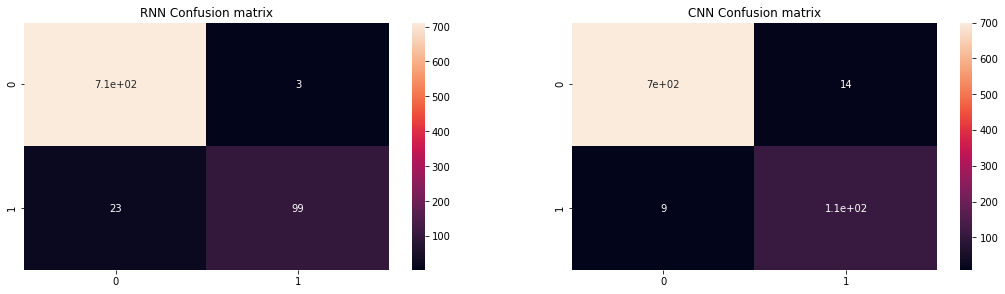

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
fig =plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

CM_RNN = confusion_matrix(y_test, RNN_pre1)
sn.heatmap(CM_RNN, annot=True, ax=ax1,
           annot_kws={"size": 10}) 
ax1.set_title('RNN Confusion matrix')


CM_CNN = confusion_matrix(y_test, CNN_pre1)
sn.heatmap(CM_CNN, annot=True, ax=ax2,
           annot_kws={"size": 10}) 
ax2.set_title('CNN Confusion matrix')
plt.show()

#### **3.3.4 Conclusion**

Compared with different metrics chosen above, the CNN model does better job with higher train & test accuracy and higher AUC score. The runing time of CNN model is also smaller. Moreover, CNN model reaches the stable situation with fewer epochs.

Besides, with comparasive analysis of both confuison matrix, althought both models can correctly identified spam emails in most cases, RNN model is more likely to fail to label spam emails with CNN model tends to misclassify non-spam emails as spam emails